In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from pathlib import Path
import sys

sys.path.append(str(Path("..").resolve()))
from config.settings import DATA_PROCESSED, RANDOM_STATE, ROOT_DIR

pd.set_option("display.float_format", "{:,.4f}".format)
print("✅ Imports OK")

✅ Imports OK


In [3]:
fm = pd.read_parquet(DATA_PROCESSED / "splitting_scores.parquet")
print(f"Loaded {len(fm):,} rows")

Loaded 1,553,594 rows


In [4]:
# Aggregate to vendor-agency edge weights first
# Edge weight = total spend from agency to vendor
print("Aggregating vendor-agency edges...")

edges = fm.groupby(["codigo_proveedor", "codigo_entidad"]).agg(
    total_spend=("valor_del_contrato", "sum"),
    contract_count=("id_contrato", "count"),
).reset_index()

print(f"Total edges (vendor-agency pairs): {len(edges):,}")
print(f"Unique vendors:                    {edges['codigo_proveedor'].nunique():,}")
print(f"Unique agencies:                   {edges['codigo_entidad'].nunique():,}")

# Build graph — only include pairs with at least 3 contracts
# Single interactions are not meaningful for network analysis
min_contracts = 3
edges_filtered = edges[edges["contract_count"] >= min_contracts].copy()
print(f"\nEdges after filtering (min {min_contracts} contracts): {len(edges_filtered):,}")

G = nx.Graph()

# Add vendor nodes
for vendor in edges_filtered["codigo_proveedor"].unique():
    G.add_node(str(vendor), node_type="vendor")

# Add agency nodes
for agency in edges_filtered["codigo_entidad"].unique():
    G.add_node(str(agency), node_type="agency")

# Add edges with attributes
for _, row in edges_filtered.iterrows():
    G.add_edge(
        str(row["codigo_proveedor"]),
        str(row["codigo_entidad"]),
        weight=row["total_spend"],
        contracts=row["contract_count"]
    )

print(f"\nGraph built:")
print(f"  Nodes: {G.number_of_nodes():,}")
print(f"  Edges: {G.number_of_edges():,}")
print(f"  Density: {nx.density(G):.6f}")

Aggregating vendor-agency edges...
Total edges (vendor-agency pairs): 712,999
Unique vendors:                    544,813
Unique agencies:                   2,359

Edges after filtering (min 3 contracts): 215,028

Graph built:
  Nodes: 196,182
  Edges: 215,027
  Density: 0.000011


In [5]:
print("Computing vendor metrics...")

vendor_nodes = [n for n, d in G.nodes(data=True) if d.get("node_type") == "vendor"]

# Degree — number of distinct agencies served
vendor_degree = {n: G.degree(n) for n in vendor_nodes}

# Weighted degree — total spend
vendor_weighted_degree = {n: sum(d["weight"] for _, _, d in G.edges(n, data=True))
                          for n in vendor_nodes}

# PageRank — identifies vendors with disproportionate influence
pagerank = nx.pagerank(G, weight="weight")

vendor_metrics = pd.DataFrame({
    "codigo_proveedor": vendor_nodes,
    "degree": [vendor_degree[n] for n in vendor_nodes],
    "total_spend": [vendor_weighted_degree[n] for n in vendor_nodes],
    "pagerank": [pagerank[n] for n in vendor_nodes],
}).sort_values("pagerank", ascending=False)

vendor_metrics["codigo_proveedor"] = vendor_metrics["codigo_proveedor"].astype(str)

# Flag vendors with high PageRank relative to degree
# These are vendors receiving preferential routing
pr_median = vendor_metrics["pagerank"].median()
deg_median = vendor_metrics["degree"].median()

vendor_metrics["flag_preferential"] = (
    (vendor_metrics["pagerank"] > pr_median * 3) &
    (vendor_metrics["degree"] <= deg_median)
).astype(int)

print(f"Vendor metrics computed for {len(vendor_metrics):,} vendors")
print(f"\nTop 10 vendors by PageRank:\n")
print(vendor_metrics.head(10)[
    ["codigo_proveedor", "degree", "total_spend", "pagerank", "flag_preferential"]
].to_string(index=False))

print(f"\nVendors flagged as preferentially routed: {vendor_metrics['flag_preferential'].sum():,}")

Computing vendor metrics...
Vendor metrics computed for 194,477 vendors

Top 10 vendors by PageRank:

codigo_proveedor  degree    total_spend  pagerank  flag_preferential
       703418913       1  9974360174872    0.0064                  1
       700660012      20 24527251529363    0.0048                  0
       703213777       1  4949865354525    0.0032                  1
       704297555       1  4949863593032    0.0032                  1
       707457016       1  2601155545554    0.0032                  1
       702453010       7  8445214327354    0.0030                  0
       700679053      72  1367315907292    0.0029                  0
       700087034      38  1034380695005    0.0027                  0
       709524052       2  1397151528511    0.0025                  0
       702138157      11  1284459400952    0.0024                  0

Vendors flagged as preferentially routed: 5,350


In [6]:
print("Computing agency metrics...")

agency_nodes = [n for n, d in G.nodes(data=True) if d.get("node_type") == "agency"]

# HHI per agency from graph edge weights
def graph_hhi(agency_node):
    neighbors = list(G.neighbors(agency_node))
    if not neighbors:
        return 0
    weights = np.array([G[agency_node][n]["weight"] for n in neighbors])
    total = weights.sum()
    if total == 0:
        return 0
    shares = weights / total
    return (shares ** 2).sum()

agency_degree = {n: G.degree(n) for n in agency_nodes}
agency_spend = {n: sum(d["weight"] for _, _, d in G.edges(n, data=True))
                for n in agency_nodes}
agency_hhi_graph = {n: graph_hhi(n) for n in agency_nodes}
agency_top_share = {}
for n in agency_nodes:
    neighbors = list(G.neighbors(n))
    if not neighbors:
        agency_top_share[n] = 0
        continue
    weights = [G[n][nb]["weight"] for nb in neighbors]
    total = sum(weights)
    agency_top_share[n] = max(weights) / total if total > 0 else 0

agency_metrics = pd.DataFrame({
    "codigo_entidad": agency_nodes,
    "distinct_vendors": [agency_degree[n] for n in agency_nodes],
    "total_spend": [agency_spend[n] for n in agency_nodes],
    "hhi": [agency_hhi_graph[n] for n in agency_nodes],
    "top_vendor_share": [agency_top_share[n] for n in agency_nodes],
}).sort_values("hhi", ascending=False)

agency_metrics["codigo_entidad"] = agency_metrics["codigo_entidad"].astype(str)

# Flag highly concentrated agencies
agency_metrics["flag_concentrated"] = (
    agency_metrics["top_vendor_share"] > 0.5
).astype(int)

print(f"Agency metrics computed for {len(agency_metrics):,} agencies")
print(f"\nTop 10 most concentrated agencies (by HHI):\n")
print(agency_metrics.head(10)[
    ["codigo_entidad", "distinct_vendors", "total_spend", "hhi", "top_vendor_share", "flag_concentrated"]
].to_string(index=False))

print(f"\nAgencies with >50% top vendor concentration: {agency_metrics['flag_concentrated'].sum():,} ({agency_metrics['flag_concentrated'].mean()*100:.1f}%)")

Computing agency metrics...
Agency metrics computed for 1,705 agencies

Top 10 most concentrated agencies (by HHI):

codigo_entidad  distinct_vendors  total_spend    hhi  top_vendor_share  flag_concentrated
     716287289                 1    896829640 1.0000            1.0000                  1
     717695126                 1     76023600 1.0000            1.0000                  1
     713766525                 1      1999200 1.0000            1.0000                  1
     705727196                 1     19585260 1.0000            1.0000                  1
     711387241                 1     30900000 1.0000            1.0000                  1
     708725528                 1     50655920 1.0000            1.0000                  1
     718555220                 1    100000000 1.0000            1.0000                  1
     714229788                 1    982848000 1.0000            1.0000                  1
     704246412                 1     50119024 1.0000            1.0000   

Building network visualization (top edges by weight)...


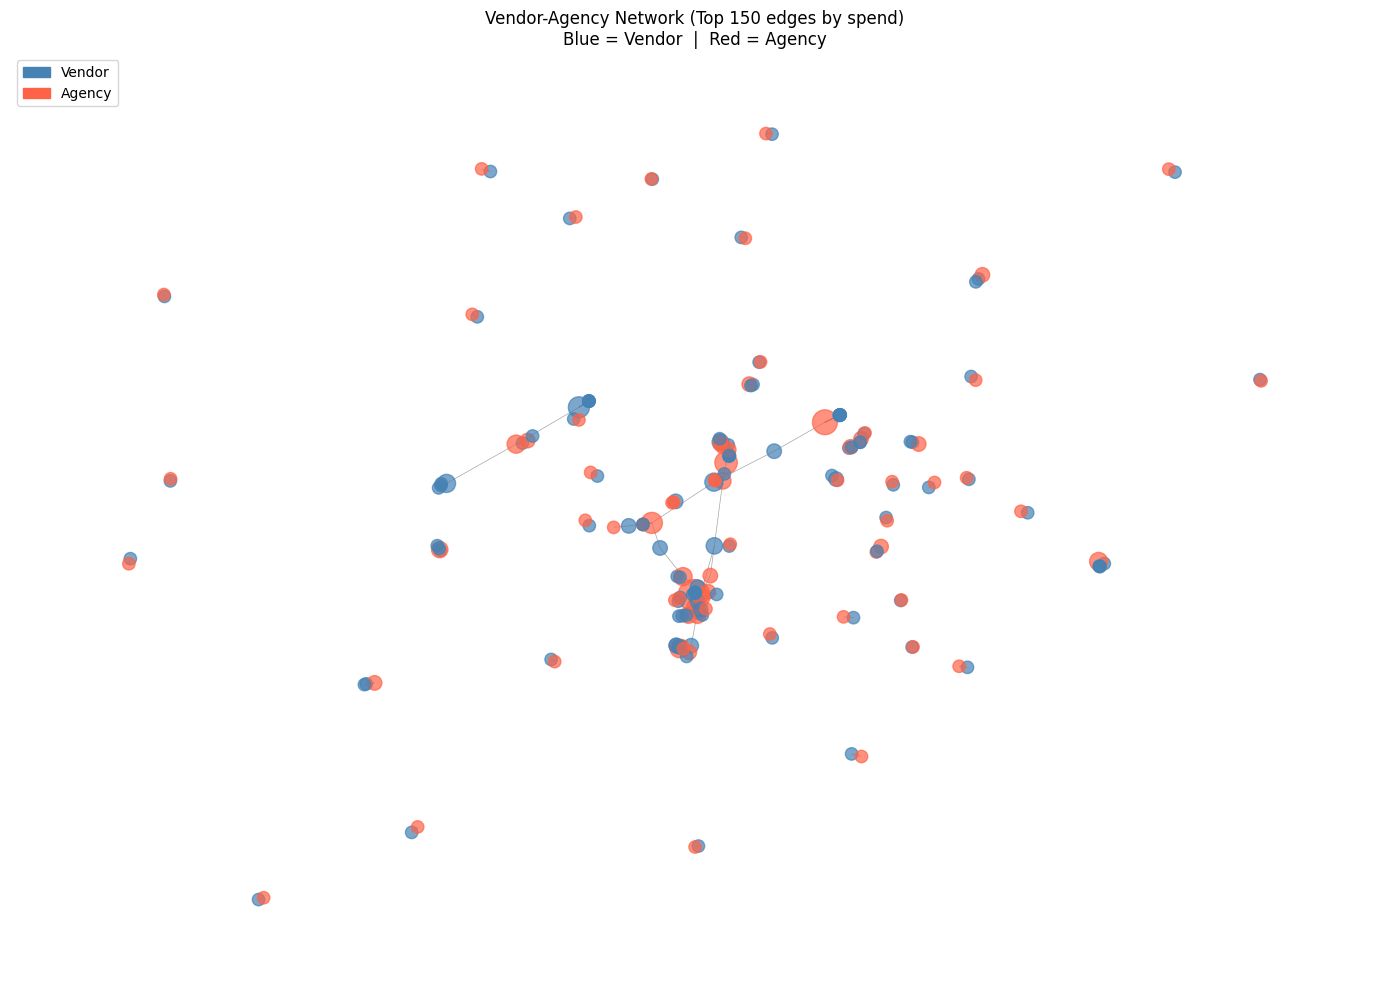

✅ Network chart saved


In [7]:
print("Building network visualization (top edges by weight)...")

# Subset to top 150 edges for readable visualization
top_edges = edges_filtered.nlargest(150, "total_spend")

G_viz = nx.Graph()
for _, row in top_edges.iterrows():
    v = str(row["codigo_proveedor"])
    a = str(row["codigo_entidad"])
    G_viz.add_node(v, node_type="vendor")
    G_viz.add_node(a, node_type="agency")
    G_viz.add_edge(v, a, weight=row["total_spend"])

# Color by node type
node_colors = [
    "steelblue" if G_viz.nodes[n].get("node_type") == "vendor" else "tomato"
    for n in G_viz.nodes()
]

# Size by degree
node_sizes = [G_viz.degree(n) * 30 + 50 for n in G_viz.nodes()]

fig, ax = plt.subplots(figsize=(14, 10))
pos = nx.spring_layout(G_viz, seed=RANDOM_STATE, k=0.5)
nx.draw_networkx(
    G_viz, pos=pos,
    node_color=node_colors,
    node_size=node_sizes,
    edge_color="gray",
    alpha=0.7,
    with_labels=False,
    width=0.5,
    ax=ax
)
ax.set_title("Vendor-Agency Network (Top 150 edges by spend)\nBlue = Vendor  |  Red = Agency")
ax.axis("off")

from matplotlib.patches import Patch
legend = [Patch(color="steelblue", label="Vendor"), Patch(color="tomato", label="Agency")]
ax.legend(handles=legend, loc="upper left")

plt.tight_layout()
plt.savefig("../outputs/charts/06_network_graph.png", dpi=150)
plt.show()
print("✅ Network chart saved")

In [8]:
# Join network metrics back to contract level
# Each contract inherits its vendor's and agency's network risk signals

vendor_metrics["codigo_proveedor"] = vendor_metrics["codigo_proveedor"].astype(str)
agency_metrics["codigo_entidad"] = agency_metrics["codigo_entidad"].astype(str)
fm["codigo_proveedor"] = fm["codigo_proveedor"].astype(str)
fm["codigo_entidad"] = fm["codigo_entidad"].astype(str)

# Normalize PageRank to [0,1]
pr_min = vendor_metrics["pagerank"].min()
pr_max = vendor_metrics["pagerank"].max()
vendor_metrics["pagerank_norm"] = (vendor_metrics["pagerank"] - pr_min) / (pr_max - pr_min)

# Join vendor metrics
fm = fm.merge(
    vendor_metrics[["codigo_proveedor", "pagerank_norm", "flag_preferential"]],
    on="codigo_proveedor", how="left"
)

# Join agency metrics
fm = fm.merge(
    agency_metrics[["codigo_entidad", "hhi", "top_vendor_share", "flag_concentrated"]],
    on="codigo_entidad", how="left",
    suffixes=("", "_graph")
)

# Fill contracts not in graph (below min_contracts threshold) with 0
for col in ["pagerank_norm", "flag_preferential", "hhi", "top_vendor_share", "flag_concentrated"]:
    if col in fm.columns:
        fm[col] = fm[col].fillna(0)

# Network concentration score — linear combination
fm["network_score"] = (
    fm["pagerank_norm"] * 0.4 +
    fm["top_vendor_share"] * 0.4 +
    fm["flag_concentrated"] * 0.2
).clip(0, 1)

print("Network score distribution:")
print(f"  Contracts with score > 0:   {(fm['network_score'] > 0).sum():,} ({(fm['network_score'] > 0).mean()*100:.1f}%)")
print(f"  Mean score:                 {fm['network_score'].mean():.4f}")
print(f"  Max score:                  {fm['network_score'].max():.4f}")

Network score distribution:
  Contracts with score > 0:   1,546,669 (99.6%)
  Mean score:                 0.1385
  Max score:                  0.8999


In [9]:
output_path = DATA_PROCESSED / "network_scores.parquet"
fm.to_parquet(output_path, index=False, compression="snappy")

print("=" * 55)
print("✅ NETWORK ANALYSIS COMPLETE")
print("=" * 55)
print(f"  Contracts analyzed:          {len(fm):,}")
print(f"  Vendors in graph:            {len(vendor_metrics):,}")
print(f"  Agencies in graph:           {len(agency_metrics):,}")
print(f"  Preferential vendors:        {vendor_metrics['flag_preferential'].sum():,}")
print(f"  Concentrated agencies:       {agency_metrics['flag_concentrated'].sum():,} ({agency_metrics['flag_concentrated'].mean()*100:.1f}%)")
print(f"  Mean network score:          {fm['network_score'].mean():.4f}")
print(f"  Saved to:                    {output_path}")
print("=" * 55)

✅ NETWORK ANALYSIS COMPLETE
  Contracts analyzed:          1,553,594
  Vendors in graph:            194,477
  Agencies in graph:           1,705
  Preferential vendors:        5,350
  Concentrated agencies:       683 (40.1%)
  Mean network score:          0.1385
  Saved to:                    C:\Users\HP\Collections\VsCode Projects\AuditLens\data\processed\network_scores.parquet


In [10]:
# ── Louvain Community Detection ───────────────────────────────────────────────
import community as community_louvain
import networkx as nx
import pandas as pd
import numpy as np

print("Running Louvain community detection...")

# Louvain requires an undirected graph
# Project the bipartite graph to a vendor-agency undirected graph
# where edge weight = total spend between vendor and agency
G_undirected = nx.Graph()

for u, v, data in G.edges(data=True):
    weight = data.get("weight", 1)
    if G_undirected.has_edge(u, v):
        G_undirected[u][v]["weight"] += weight
    else:
        G_undirected.add_edge(u, v, weight=weight)

print(f"Undirected graph: {G_undirected.number_of_nodes():,} nodes, {G_undirected.number_of_edges():,} edges")

# Run Louvain
partition = community_louvain.best_partition(G_undirected, weight="weight", random_state=42)

# Compute modularity score (0 = random, 1 = perfect community structure)
modularity = community_louvain.modularity(partition, G_undirected, weight="weight")
n_communities = len(set(partition.values()))

print(f"\nCommunities detected: {n_communities:,}")
print(f"Modularity score:     {modularity:.4f}")
print(f"(Modularity > 0.3 indicates meaningful community structure)")

Running Louvain community detection...
Undirected graph: 196,182 nodes, 215,027 edges

Communities detected: 186
Modularity score:     0.8786
(Modularity > 0.3 indicates meaningful community structure)


In [12]:
# ── Community Risk Analysis ───────────────────────────────────────────────────

fm["community_id"] = fm["codigo_proveedor"].astype(str).map(partition)

community_stats = fm.groupby("community_id").agg(
    n_contracts=("id_contrato", "count"),
    n_vendors=("codigo_proveedor", "nunique"),
    n_agencies=("codigo_entidad", "nunique"),
    total_spend=("valor_del_contrato", "sum"),
    direct_rate=("is_direct", "mean"),
    modified_rate=("is_modified", "mean"),
    proxy_rate=("proxy_strong", "mean"),
).reset_index().sort_values("total_spend", ascending=False)

proxy_75th  = community_stats["proxy_rate"].quantile(0.75)
spend_75th  = community_stats["total_spend"].quantile(0.75)
spend_25th  = community_stats["total_spend"].quantile(0.25)
proxy_90th  = community_stats["proxy_rate"].quantile(0.90)

community_stats["flag_systemic"] = (
    (community_stats["proxy_rate"]  > proxy_75th) &
    (community_stats["total_spend"] > spend_75th)
).astype(int)

community_stats["flag_collusion"] = (
    (community_stats["proxy_rate"]  > proxy_90th) &
    (community_stats["total_spend"] > spend_25th)
).astype(int)

community_stats["flag_tight_community"] = (
    (community_stats["flag_systemic"] == 1) |
    (community_stats["flag_collusion"] == 1)
).astype(int)

n_flagged     = community_stats["flag_tight_community"].sum()
n_systemic    = community_stats["flag_systemic"].sum()
n_collusion   = community_stats["flag_collusion"].sum()
flagged_spend = community_stats[community_stats["flag_tight_community"]==1]["total_spend"].sum()
total_spend   = community_stats["total_spend"].sum()

print(f"Thresholds:")
print(f"  Proxy rate 75th pct: {proxy_75th:.3f}  |  90th pct: {proxy_90th:.3f}")
print(f"  Spend 75th pct: {spend_75th/1e12:.2f}T COP  |  25th pct: {spend_25th/1e12:.4f}T COP")
print(f"\nType A flagged (systemic):        {n_systemic}")
print(f"Type B flagged (collusion):       {n_collusion}")
print(f"Total flagged communities:        {n_flagged}")
print(f"Flagged spend: {flagged_spend/1e12:.2f} trillion COP ({flagged_spend/total_spend*100:.1f}% of total)")

print(f"\nFlagged communities detail:")
print(community_stats[community_stats["flag_tight_community"]==1][[
    "community_id", "n_vendors", "n_agencies",
    "total_spend", "proxy_rate", "flag_systemic", "flag_collusion"
]].sort_values("total_spend", ascending=False).to_string(index=False))

Thresholds:
  Proxy rate 75th pct: 0.164  |  90th pct: 0.333
  Spend 75th pct: 0.40T COP  |  25th pct: 0.0002T COP

Type A flagged (systemic):        12
Type B flagged (collusion):       11
Total flagged communities:        20
Flagged spend: 64.26 trillion COP (22.6% of total)

Flagged communities detail:
 community_id  n_vendors  n_agencies    total_spend  proxy_rate  flag_systemic  flag_collusion
      13.0000       4336         146 21225314871041      0.6831              1               1
      14.0000      13767         665 14864705506607      0.5274              1               1
       8.0000       2505         726 10304890981540      0.1997              1               0
       5.0000       8597         783  4721187715401      0.1869              1               0
      56.0000       1227         177  3958073708832      0.2913              1               0
       9.0000       7564         434  2188505121637      0.3864              1               1
      12.0000        764    

In [15]:
# ── Community Score and Save ──────────────────────────────────────────────────

# Normalize community proxy rate to [0,1] for scoring
pmax = community_stats["proxy_rate"].max()
pmin = community_stats["proxy_rate"].min()

comm_proxy_norm = (
    (community_stats.set_index("community_id")["proxy_rate"] - pmin)
    / (pmax - pmin + 1e-9)
)
comm_flag = community_stats.set_index("community_id")["flag_tight_community"]

fm["community_proxy_norm"] = fm["community_id"].map(comm_proxy_norm).fillna(0)
fm["community_flag"]       = fm["community_id"].map(comm_flag).fillna(0)

fm["community_score"] = (
    fm["community_proxy_norm"] * 0.7 +
    fm["community_flag"]       * 0.3
).clip(0, 1)

print("Community score distribution:")
print(fm["community_score"].describe().round(4))
print(f"\nContracts with community_score > 0.5: {(fm['community_score'] > 0.5).sum():,}")
print(f"Contracts in flagged communities:      {(fm['community_flag'] == 1).sum():,}")

# Diagnose duplicates before saving
print(f"\nTotal rows in fm:              {len(fm):,}")
print(f"Unique id_contrato in fm:      {fm['id_contrato'].nunique():,}")
print(f"Duplicate rows:                {len(fm) - fm['id_contrato'].nunique():,}")

# Pull only the 3 new community columns and merge onto the
# original splitting_scores file which has clean unique rows
splitting = pd.read_parquet(DATA_PROCESSED / "splitting_scores.parquet")
print(f"\nSplitting scores rows (clean baseline): {len(splitting):,}")

# Build community lookup from fm — one row per id_contrato
community_lookup = (
    fm[["id_contrato", "community_id", "community_score", "community_flag"]]
    .drop_duplicates("id_contrato")
)
print(f"Community lookup rows: {len(community_lookup):,}")

# Merge community columns onto the full fm from notebook 05
# Then merge all network columns
network_lookup = (
    fm[["id_contrato", "network_score", "pagerank_norm", "flag_preferential",
        "top_vendor_share", "flag_concentrated"]]
    .drop_duplicates("id_contrato")
)

net_clean = (
    splitting
    .merge(network_lookup, on="id_contrato", how="left")
    .merge(community_lookup, on="id_contrato", how="left")
)

for col in ["community_id", "community_score", "community_flag"]:
    net_clean[col] = net_clean[col].fillna(0)

net_clean.to_parquet(DATA_PROCESSED / "network_scores.parquet", index=False, compression="snappy")

# Save community stats separately
community_stats.to_parquet(DATA_PROCESSED / "community_stats.parquet", index=False)
community_stats.to_csv(ROOT_DIR / "outputs" / "tables" / "community_stats.csv", index=False)

print(f"\n✅ Community detection complete")
print(f"   Communities detected:     {n_communities:,}")
print(f"   Modularity score:         {modularity:.4f}")
print(f"   Flagged communities:      {n_flagged}")
print(f"   Flagged spend:            {flagged_spend/1e12:.2f} trillion COP")
print(f"   Rows saved:               {len(net_clean):,}  (must be 1,553,594)")
print(f"   Contracts in flagged:     {(fm['community_flag']==1).sum():,}")
print(f"   network_scores updated:   ✅")
print(f"   community_stats saved:    ✅")

Community score distribution:
count   1,553,594.0000
mean            0.1154
std             0.1896
min             0.0000
25%             0.0000
50%             0.0586
75%             0.0940
max             0.9149
Name: community_score, dtype: float64

Contracts with community_score > 0.5: 128,751
Contracts in flagged communities:      223,375

Total rows in fm:              1,553,594
Unique id_contrato in fm:      1,475,501
Duplicate rows:                78,093

Splitting scores rows (clean baseline): 1,553,594
Community lookup rows: 1,475,501

✅ Community detection complete
   Communities detected:     186
   Modularity score:         0.8786
   Flagged communities:      20
   Flagged spend:            64.26 trillion COP
   Rows saved:               1,553,594  (must be 1,553,594)
   Contracts in flagged:     223,375
   network_scores updated:   ✅
   community_stats saved:    ✅
